# Clever filtering using pytorch optimizers and layers

I didn't have good luck using my own gradient descent so I'm using this as an opportunity to learn the higher level pytorch mechanisms like `torch.nn`. This [tutorial on pytorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) is very good.

## Support code

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [3]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1  NB: Different than I usually do (1..n)!!!!
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [4]:
def mae(y_pred, y):
    return torch.mean( (y_pred - y).abs() )

In [5]:
def train_test_split(data, test_size:float):
    n = len(data)
    n_valid = int(n*test_size)
    n_train = n - n_valid
    indices = torch.randperm(n)
    train_idx = indices[0:n_train]
    test_idx = indices[n_train:]
    train, test = data[train_idx], data[test_idx] # copying data but could not get columns out of a Subset object
    # train, valid = data, data
    X_train = train[:,[0,1]].float()
    X_test = test[:,[0,1]].float()
    y_train = train[:,2].float()
    y_test = test[:,2].float()
    return X_train, X_test, y_train, y_test

In [6]:
def top_movies(df, n=100):
    rating_count = df.groupby('movieId')['rating'].count()
    top_movieIds = rating_count.sort_values(ascending=False).index.values[:n]

    df_top = df[df['movieId'].isin(top_movieIds)][['movieId','title','genres']].drop_duplicates()
    return df_top

In [7]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [8]:
from sklearn.decomposition import PCA

def mcolor(genre):
    if 'Comedy' in genre: return 'green'
    if 'Sci-Fi' in genre: return 'cyan'
    if 'War' in genre: return 'red'
    if 'Drama' in genre: return '#FEE08F'
    return 'black'

def plot_comedy_drama_embeddings(df, movie_embeddings, n=1000, xrange=(-1,1), yrange=(-1,1)):
#    df_movies = df[(df['genres'].str.contains('Comedy'))|(df['genres'].str.contains('Drama'))]
#     df_movies = top_movies(df_movies, n)
    df_movies = top_movies(df, n)
    movie_embeddings = movie_embeddings[df_movies['movieId'].values]
    
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [mcolor(genres[i]) for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5, alpha=.5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()
    return df_movies, vecs2D

In [9]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

output_notebook() # send to notebook not tab

def plot_bokeh_comend_drama_embeddings(df_movies, vecs2D):
    data = dict(
        x=vecs2D[:,0],
        y=vecs2D[:,1],
        title = df_movies['title'],
        genre = df_movies['genres'],
        colors = [mcolor(df_movies['genres'].iloc[i]) for i in range(len(vecs2D))]
    )
    source = ColumnDataSource(data)
    fig = figure(plot_width=500, plot_height=300,
                 title='Movie embeddings projected with PCA',
                 tools='pan,wheel_zoom,zoom_in,box_zoom,reset,hover',
                 x_axis_type=None, y_axis_type=None, min_border=1)
    fig.scatter(x='x', y='y',source=source, fill_alpha=0.7, size=5, fill_color='colors')
    # hover tools,
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = {'content': '@title'}
    show(fig)

Loading BokehJS ...

## Load and train with no mini-batch

In [10]:
df = load(n=20_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,132,80,3.0,Braveheart,Action|Drama|War
1,386,80,3.5,Braveheart,Action|Drama|War


In [11]:
avg_rating = np.mean(df['rating'])
avg_rating

3.49595

16000 training and 4000 test records
Init      L2 MSE loss 2.925, 2.900   MAE 1.397, 1.387
Epoch   0 L2 MSE loss 2.925, 2.891   MAE 1.394, 1.385
Epoch  20 L2 MSE loss 2.706, 2.691   MAE 1.330, 1.329
Epoch  40 L2 MSE loss 2.402, 2.417   MAE 1.234, 1.244
Epoch  60 L2 MSE loss 2.015, 2.075   MAE 1.102, 1.130
Epoch  80 L2 MSE loss 1.604, 1.723   MAE 0.962, 1.013
Epoch 100 L2 MSE loss 1.256, 1.436   MAE 0.816, 0.894
Epoch 120 L2 MSE loss 1.012, 1.243   MAE 0.741, 0.845
Epoch 140 L2 MSE loss 0.857, 1.127   MAE 0.685, 0.811
Epoch 160 L2 MSE loss 0.758, 1.057   MAE 0.645, 0.789
Epoch 180 L2 MSE loss 0.693, 1.013   MAE 0.616, 0.775
Epoch 200 L2 MSE loss 0.647, 0.986   MAE 0.593, 0.765
Epoch 220 L2 MSE loss 0.614, 0.968   MAE 0.576, 0.759
Epoch 240 L2 MSE loss 0.588, 0.958   MAE 0.562, 0.755
Epoch 260 L2 MSE loss 0.569, 0.952   MAE 0.552, 0.754
Epoch 280 L2 MSE loss 0.553, 0.950   MAE 0.544, 0.753


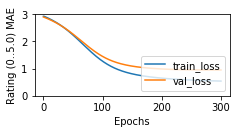

In [12]:
import torch.nn as nn

class CollabFilter(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilter, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1, keepdim=False)
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output
    
data = torch.tensor( df[['userId','movieId','rating']].values )
X_train, X_valid, y_train, y_valid = train_test_split(data, 0.20)
print(f"{len(X_train)} training and {len(X_valid)} test records")

model = CollabFilter(nusers, nmovies, nfactors=10)
loss_fn = torch.nn.MSELoss()

learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # model.parameters is just [U,M]

history = []

# Start history with what random weights show
with torch.no_grad():
    loss = loss_fn(model(X_train), y_train)
    loss_valid = loss_fn(model(X_valid), y_valid)
    mae_train = mae(model(X_train), y_train).detach().item()
    mae_valid = mae(model(X_valid), y_valid).detach().item()
history.append( (loss, loss_valid) )
print(f"Init      L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

for t in range(300): # epochs
    r_pred = model(X_train)
    loss = loss_fn(r_pred, y_train)

    optimizer.zero_grad()
    loss.backward() # autograd computes U.grad and M.grad
    optimizer.step()

    with torch.no_grad():
        loss_valid = loss_fn(model(X_valid), y_valid)
        mae_train = mae(model(X_train), y_train).detach().item()
        mae_valid = mae(model(X_valid), y_valid).detach().item()

    history.append( (loss, loss_valid) )
    if t % 20 == 0:
        print(f"Epoch {t:3d} L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

history = torch.tensor(history)

plot_history(history, yrange=(0,3), figsize=(3.5,1.5))

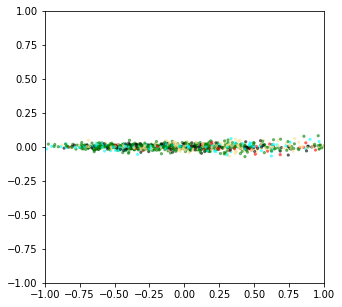

In [13]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, model.M.cpu().detach().numpy(), n=1000)#, xrange=(-3,3), yrange=(-3,3))

In [14]:
plot_bokeh_comend_drama_embeddings(df_movies, vecs2D)

## Make my own pytorch "module"

Train again but no minibatch